# Generative Adversarial Networks (GAN) Demo

This notebook demonstrates how to use the GAN toolkit to load data, initialize models, and generate images using a DCGAN.

## 1. Setup

### 1.1. Import Necessary Modules

In [1]:
# Import standard libraries
import os
import sys
import yaml
import torch
import matplotlib.pyplot as plt

# Ensure the project root is in the Python path
sys.path.append('../')

# Import custom modules from the GAN toolkit
from src.datasets.dataloader import get_data_loader
from src.models.dcgan import Generator, Discriminator
from src.utils.device import get_device
from src.utils.visualization import denorm

# Set matplotlib to display inline
%matplotlib inline

### 1.2. Load Configuration

In [2]:
# Load the configuration file
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Access configuration parameters
data_config = config['data']
model_config = config['model']
training_config = config['training']

print("Configuration loaded successfully.")

Configuration loaded successfully.


### 1.3. Set Device

In [3]:
# Get the available device (GPU or CPU)
device = get_device()
print(f'Using device: {device}')

Using device: mps


## 2. Data Preparation

### 2.1. Download the Dataset (If Not Already Downloaded)

In [6]:
import os

# Check if the dataset directory exists
dataset_path = data_config['dataset_path']
if not os.path.exists(dataset_path):
    print(f"Dataset not found at {dataset_path}. Downloading dataset...")
    import opendatasets as od
    
    # Define the dataset URL (update this URL if you're using a different dataset)
    dataset_url = 'https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification'
    
    # Download the dataset using opendatasets
    od.download(dataset_url, data_dir='../data')
    
    print("Dataset downloaded successfully.")
else:
    print(f"Dataset found at {dataset_path}.")


Dataset not found at ./data/[dataset_name]. Downloading dataset...
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  georgiospathanasiou


Your Kaggle Key:

  ········


/Users/gathanasiou/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset URL: https://www.kaggle.com/datasets/balabaskar/wonders-of-the-world-image-classification


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 432M/432M [01:18<00:00, 5.74MB/s]



Dataset downloaded successfully.


### 2.2. Load Data

In [4]:
# Get the data loader
data_loader = get_data_loader(
    data_dir=data_config['dataset_path'],
    image_size=data_config['image_size'],
    batch_size=training_config['batch_size'],
    num_workers=data_config['num_workers'],
    stats=(data_config['mean'], data_config['std'])
)

print("Data loader prepared.")

Data loader prepared.


### 2.3. Visualize Sample Images

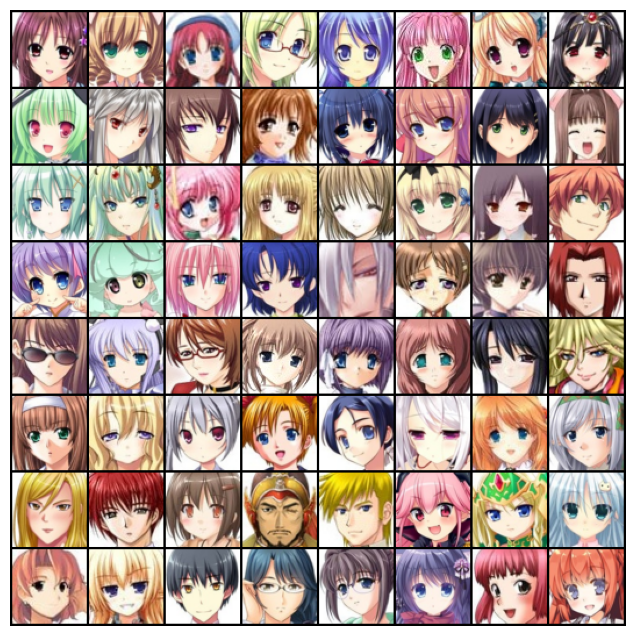

In [7]:
import torchvision

stats = (data_config['mean'], data_config['std'])
    
# Get a batch of real images
real_images, _ = next(iter(data_loader))

# Denormalize images for visualization
nmax = 64
real_images_denorm = denorm(real_images.detach()[:nmax], stats)

# Function to display images
def show_images_grid(images, nrow=8):
    grid_img = torchvision.utils.make_grid(images, nrow=nrow)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

# Show images
show_images_grid(real_images_denorm)

## 3. Model Initialization

### 3.1. Initialize Generator and Discriminator

In [8]:
# Initialize the Generator
generator = Generator(
    latent_size=model_config['latent_size'],
    image_channels=data_config['image_channels'],
    feature_g=model_config['feature_g']
).to(device)

# Initialize the Discriminator
discriminator = Discriminator(
    image_channels=data_config['image_channels'],
    feature_d=model_config['feature_d']
).to(device)

print("Models initialized and moved to device.")

Models initialized and moved to device.


### 3.2. Model Summaries

In [9]:
# Print model summaries
print("Generator:")
print(generator)

print("\nDiscriminator:")
print(discriminator)

Generator:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ta

## 4. Generate Fake Images

### 4.1. Generate Images Using the Generator

In [11]:
# Generate random noise
latent_size = 128
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)
# fake_images = generator(fixed_noise)

# Generate fake images
with torch.no_grad():
    fake_images = generator(fixed_noise).cpu()

print("Fake images generated.")

Fake images generated.


### 4.2. Visualize Generated Images

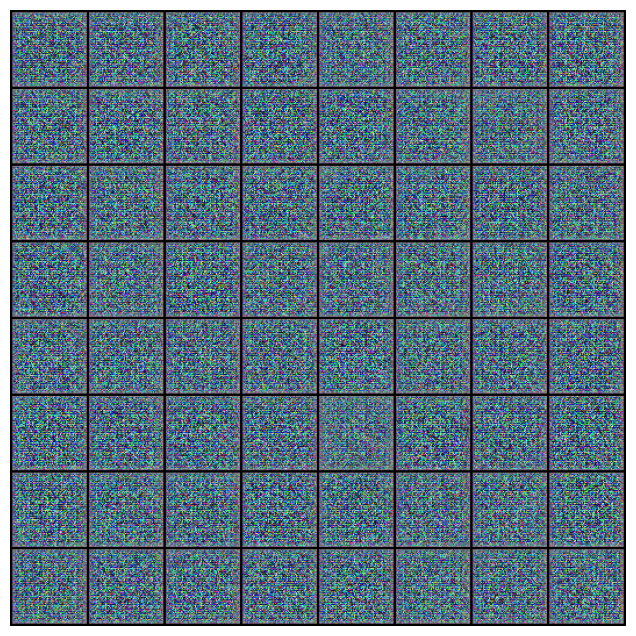

In [13]:
# Denormalize fake images for visualization
fake_images_denorm = denorm(fake_images, stats=stats)

# Show fake images
show_images_grid(fake_images_denorm)

## 5. (Optional) Simplified Training Loop

Note: This section provides a simplified training loop for demonstration purposes. Training a GAN can take a significant amount of time and resources.

### 5.1. Define Loss Function and Optimizers

In [14]:
import torch.nn as nn
import torch.optim as optim

# Define loss function
criterion = nn.BCELoss()

# Define optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=training_config['learning_rate'], betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=training_config['learning_rate'], betas=(0.5, 0.999))

print("Loss function and optimizers defined.")

Loss function and optimizers defined.


### 5.2. Training Loop for One Epoch

In [16]:
# Training parameters
num_epochs = 1  # Set to a small number for demonstration
real_label = 1.
fake_label = 0.

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(data_loader):
        # Move real images to device
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Train Discriminator with real images
        discriminator.zero_grad()
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputs = discriminator(real_images)
        loss_d_real = criterion(outputs, labels)
        loss_d_real.backward()
        real_score = outputs.mean().item()
        
        # Generate fake images
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = generator(noise)
        
        # Train Discriminator with fake images
        labels.fill_(fake_label)
        outputs = discriminator(fake_images.detach())
        loss_d_fake = criterion(outputs, labels)
        loss_d_fake.backward()
        fake_score = outputs.mean().item()
        
        # Update Discriminator
        loss_d = loss_d_real + loss_d_fake
        optimizer_d.step()
        
        # Train Generator
        generator.zero_grad()
        labels.fill_(real_label)
        outputs = discriminator(fake_images)
        loss_g = criterion(outputs, labels)
        loss_g.backward()
        optimizer_g.step()
        
        # Print training stats
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], "
                  f"D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}, "
                  f"Real Score: {real_score:.4f}, Fake Score: {fake_score:.4f}")
        
        # For demonstration, break after first batch
        break  # Remove this break statement to run through the entire epoch

print("Training completed for one epoch.")

Training completed for one epoch.


### 5.3. Generate Images After Training

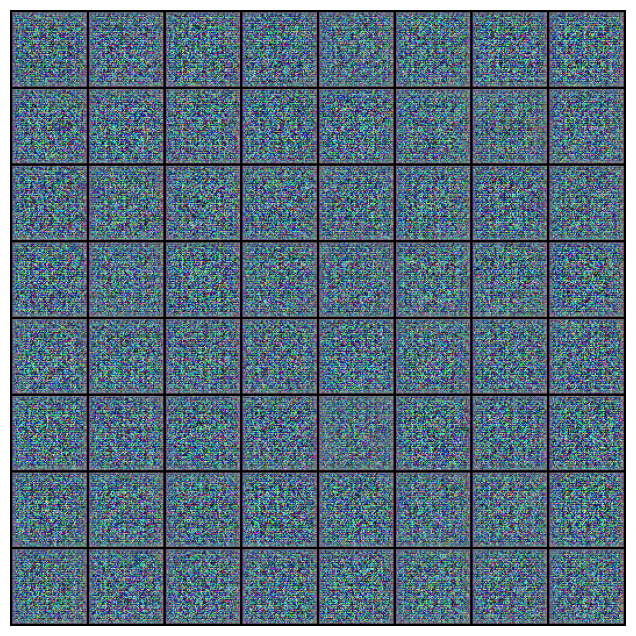

In [18]:
# Generate fake images after training
with torch.no_grad():
    fake_images = generator(fixed_noise).cpu()

# Denormalize and visualize
fake_images_denorm = denorm(fake_images, stats=stats)
show_images_grid(fake_images_denorm)